# TP3

## Imports

In [55]:
import collections
import os
import string
import sys

import pandas as pd
from nltk import word_tokenize
from nltk.corpus import stopwords
from pprint import pprint
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec



In [ ]:
import nltk
from nltk.tokenize import wordpunct_tokenize
from unidecode import unidecode
from timeout_decorator import timeout, TimeoutError
from threading import Timer
from yake import KeywordExtractor
import nltk

nltk.download('punkt')

In [58]:
data_path = "../data/txt/"

In [59]:
DECADE = '1910'

In [60]:
files = [f for f in sorted(os.listdir(data_path)) if f"_{DECADE[:-1]}" in f]

## Choisir de la décennie

In [ ]:
# Exemple de fichiers
files[:5]


In [62]:
texts = [open(data_path + f, "r", encoding="utf-8").read() for f in files]

In [ ]:
# Exemple de textes
texts[0][:400]

## Vectoriser les documents à l'aide de TF-IDF

In [10]:
# Création d'une fonction de pré-traitement
def preprocessing(text, stem=True):
    """ Tokenize text and remove punctuation """
    text = text.translate(string.punctuation)
    tokens = word_tokenize(text)
    return tokens

### Instancier le modèle TF-IDF avec ses arguments

In [11]:
vectorizer = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words=stopwords.words('french'),
    max_df=0.5,
    min_df=0.1,
    lowercase=True)

### Construire la matrice de vecteurs à l'aide de la fonction `fit_transform`

In [ ]:
tfidf_vectors = vectorizer.fit_transform(texts)

In [ ]:
# Détail de la matrice
tfidf_vectors

### Imprimer le vecteur tf-IDF du premier document

In [ ]:
pd.Series(
    tfidf_vectors[0].toarray()[0],
    index=vectorizer.get_feature_names_out()
    ).sort_values(ascending=False)

## Comprendre les vecteurs et leurs "distances"

In [ ]:
cosine([1, 2, 3], [1, 2, 3])

In [ ]:
cosine([1, 2, 3], [1, 2, 2])

In [ ]:
cosine([1, 2, 3], [2, 2, 2])

### Tests sur nos documents

In [18]:
tfidf_array = tfidf_vectors.toarray()

In [ ]:
# Vecteur du document 0
tfidf_array[0]

In [ ]:
# Vecteur du document 1
tfidf_array[1]

In [ ]:
cosine(tfidf_array[0], tfidf_array[1])

## Appliquer un algorithme de clustering sur les vecteurs TF-IDF des documents

Pour en savoir plus sur le KMeans clustering :
- https://medium.com/dataseries/k-means-clustering-explained-visually-in-5-minutes-b900cc69d175

### Définir un nombre de clusters

In [21]:
N_CLUSTERS = 4

### Instancier le modèle K-Means et ses arguments

In [22]:
km_model = KMeans(n_clusters=N_CLUSTERS)

### Appliquer le clustering à l'aide de la fonction `fit_predict`

In [ ]:
clusters = km_model.fit_predict(tfidf_vectors)

In [24]:
clustering = collections.defaultdict(list)

for idx, label in enumerate(clusters):
    clustering[label].append(files[idx])

In [ ]:
pprint(dict(clustering))

### visualiser le contenu des differents textes de chaque clusters 

In [ ]:
# Lecture du  contenu des clusters avec une limite de temps
def read_file_content(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        return f.read()

# gestion  du  délai d'exécution
def timeout_handler():
    raise TimeoutError("Function execution timed out")

# Exploration des données brutes de chaque cluster
for cluster_label, files_in_cluster in clustering.items():
    print(f"Cluster {cluster_label} :")
    #pprint(files_in_cluster)
    print("\n")

   
    content_list = []
    for txt in files_in_cluster:
        timer = Timer(5, timeout_handler)  
        try:
            timer.start()
            content = read_file_content(os.path.join(data_path, txt))
            content_list.append(content)
        except TimeoutError:
            print(f"Reading {txt} took too long. Skipping.")
            continue
        finally:
            timer.cancel()

    # Afficher le contenu de chaque texte dans le cluster
    for txt in files_in_cluster:
        try:
            content = read_file_content(os.path.join(data_path, txt))
            print(f"Text in Cluster {cluster_label}:")
            print(content)
            print("\n")
        except TimeoutError:
            print(f"Reading {txt} took too long. Skipping.")

In [ ]:
# Stockage du contenu de chaque cluster dans une liste
all_cluster_content = []

# Exploration des données brutes de chaque cluster
for cluster_label, files_in_cluster in clustering.items():
   

    
    cluster_content = ""
    for txt in files_in_cluster:
        try:
            content = read_file_content(os.path.join(data_path, txt))
            cluster_content += content + "\n"  
        except TimeoutError:
            print(f"Reading {txt} took too long. Skipping.")

    # Ajouter le contenu du cluster au corpus global
    all_cluster_content.append(cluster_content)

# Afficher le contenu de chaque cluster
for cluster_label, cluster_content in zip(clustering.keys(), all_cluster_content):
    print(f"Cluster {cluster_label} - All Content:")
    print(cluster_content)
    print("\n")

    



### Extraction de keywords des differents clusters 

### Keywords pour chaque clusters 

In [ ]:

kw_extractor = KeywordExtractor()

all_cluster_keywords = []

for cluster_label, files_in_cluster in clustering.items():
  
    cluster_content = ""
    for txt in files_in_cluster:
        try:
            content = read_file_content(os.path.join(data_path, txt))
            cluster_content += content + "\n"  # Concaténer le contenu des textes avec un saut de ligne
        except TimeoutError:
            print(f"Reading {txt} took too long. Skipping.")

    # Extraction des mots-clés du contenu du cluster
    cluster_keywords = kw_extractor.extract_keywords(cluster_content)

   
    all_cluster_keywords.append(cluster_keywords)

# Affichage des mots-clés de chaque cluster
for cluster_label, cluster_keywords in zip(clustering.keys(), all_cluster_keywords):
    print(f"Cluster {cluster_label} - Keywords:")
    pprint(cluster_keywords)
    print("\n")


In [33]:
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(tfidf_vectors.toarray())

In [ ]:
reduced_vectors[:10]

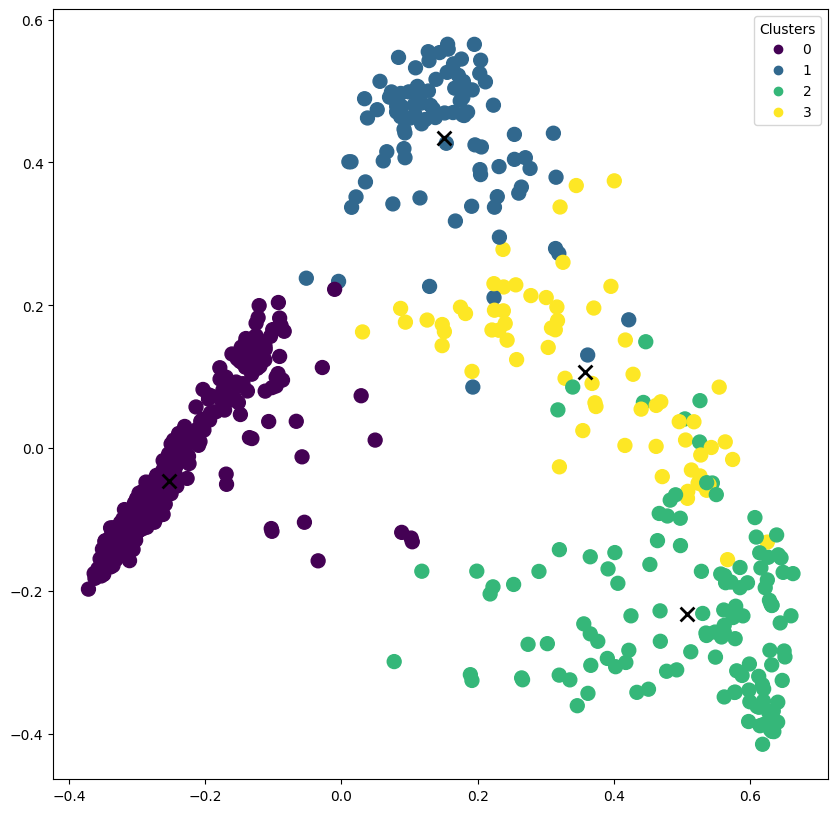

In [38]:
x_axis = reduced_vectors[:, 0]
y_axis = reduced_vectors[:, 1]

plt.figure(figsize=(10,10))
scatter = plt.scatter(x_axis, y_axis, s=100, c=clusters)

# Ajouter les centroïdes
centroids = pca.transform(km_model.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1],  marker = "x", s=100, linewidths = 2, color='black')

# Ajouter la légende
plt.legend(handles=scatter.legend_elements()[0], labels=set(clusters), title="Clusters")

### WORD_EMBEDDING 

### Création d'un objet qui *streame* les lignes d'un fichier pour économiser de la RAM

In [64]:
class MySentences(object):
    """Tokenize and Lemmatize sentences"""
    def __init__(self, filename):
        self.filename = filename

    def __iter__(self):
        for line in open(self.filename, encoding='utf-8', errors="backslashreplace"):
            yield [unidecode(w.lower()) for w in wordpunct_tokenize(line)]

In [65]:
infile = f"../data/sents.txt"
sentences = MySentences(infile)

### Détection des bigrams

Article intéressant sur le sujet : https://towardsdatascience.com/word2vec-for-phrases-learning-embeddings-for-more-than-one-word-727b6cf723cf

In [66]:
bigram_phrases = Phrases(sentences)

L'object `phrases` peut être vu comme un large dictionnaire d'expressions multi-mots associées à un score, le *PMI-like scoring*. Ce dictionnaire est construit par un apprentissage sur base d'exemples.
Voir les références ci-dessous :
- https://arxiv.org/abs/1310.4546
- https://en.wikipedia.org/wiki/Pointwise_mutual_information

In [67]:
type(bigram_phrases.vocab)

dict

Il contient de nombreuses clés qui sont autant de termes observés dans le corpus

In [68]:
len(bigram_phrases.vocab.keys())


0

Prenons une clé au hasard :

In [ ]:
key_ = list(bigram_phrases.vocab.keys())[144]
print(key_)

Le dictionnaire indique le score de cette coocurrence :

In [ ]:
bigram_phrases.vocab[key_]

### Conversion des `Phrases` en objet `Phraser`

`Phraser` est un alias pour `gensim.models.phrases.FrozenPhrases`, voir ici https://radimrehurek.com/gensim/models/phrases.html.

Le `Phraser` est une version *light* du `Phrases`, plus optimale pour transformer les phrases en concaténant les bigrams.

In [71]:
bigram_phraser = Phraser(phrases_model=bigram_phrases)

### Extraction des trigrams

In [72]:
trigram_phrases = Phrases(bigram_phraser[sentences])

In [73]:
trigram_phraser = Phraser(phrases_model=trigram_phrases)

### Création d'un corpus d'unigrams, bigrams, trigrams

In [74]:
corpus = list(trigram_phraser[bigram_phraser[sentences]])

In [75]:
print(corpus[:100])

[]


## Entrainement d'un modèle Word2Vec sur ce corpus

In [ ]:
%%time
model = Word2Vec(
    corpus, # On passe le corpus de ngrams que nous venons de créer
    vector_size=32, # Le nombre de dimensions dans lesquelles le contexte des mots devra être réduit, aka. vector_size
    window=5, # La taille du "contexte", ici 5 mots avant et après le mot observé
    min_count=5, # On ignore les mots qui n'apparaissent pas au moins 5 fois dans le corpus
    workers=4, # Permet de paralléliser l'entraînement du modèle en 4 threads
    epochs=5 # Nombre d'itérations du réseau de neurones sur le jeu de données pour ajuster les paramètres avec la descente de gradient, aka. epochs.
)

In [ ]:


# Définir différentes valeurs pour window et min_count
window_values = [3, 5, 7]
min_count_values = [3, 5, 10]

# Des essais-erreurs
best_model = None
best_score = float('-0.01')  

for window_size in window_values:
    for min_count_value in min_count_values:
        print(f"Entraînement avec window={window_size}, min_count={min_count_value}")
        
        # Entraînement du modèle
        model = Word2Vec(
            corpus,
            vector_size=32,
            window=window_size,
            min_count=min_count_value,
            workers=4,
            epochs=5
        )

        score = len(model.wv.key_to_index)

        print(f"Score obtenu : {score}\n")

        # Comparaison avec le meilleur modèle précédent
        if score > best_score:
            best_score = score
            best_model = model

print("Entraînement terminé.")


### Sauver le modèle dans un fichier

In [ ]:
outfile = f"../data/newspapers.model"
model.save(outfile)

## Explorer le modèle

### Charger le modèle en mémoire

In [ ]:
model = Word2Vec.load("../data/newspapers.model")